# Speech emotion recognition using TESS Toronto dataset

In this notebook I have analyzed the TESS Toronto dataset, containing around 2800 audio files in WAV format. The files contain 200 target words that were spoken in the phrase "Say the word_' by two different voice, and each of the recording portrays one of seven different emotions: anger, disgust, fear, happiness, pleasant surprise, sadness, and neutral.
The goal of this notebook is to analyze the audio files and build a model able to predict the correct emotion of the recording.

In the following, different machine learning algorithms are tested:
* Support vector machine
* K-nearest neighbors
* Random forest
* Gradient boosting decision trees

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

The library that we will use for visualization of the audio files is 'librosa':

In [2]:
import librosa

In [3]:
main_path = 'TESS Toronto emotional speech set data/'

### Playing one of the audio files:

In [4]:
single_file = main_path+'OAF_angry/OAF_back_angry.wav'

In [5]:
import IPython.display as ipd
ipd.Audio(single_file)

### Visualizing spectrum of the audio file:

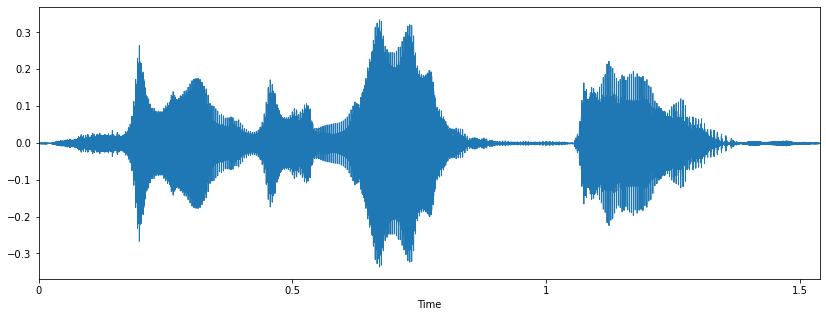

In [6]:
import librosa.display
plt.figure(figsize=(14, 5))
y, sr = librosa.load(single_file)
librosa.display.waveplot(y,sr)

### Spectrogram:

This shows the strength of the signal at different times and frequencies, using a heat map:

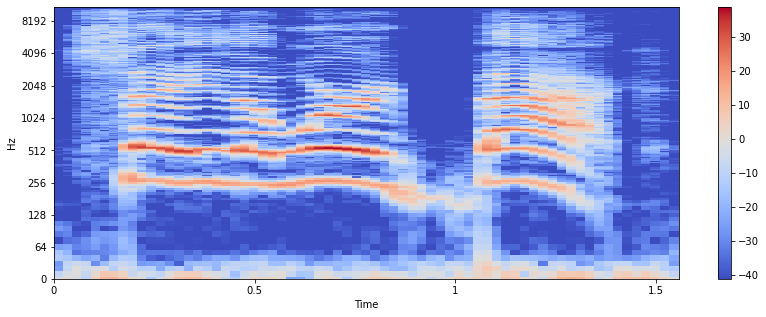

In [7]:
Y = librosa.stft(y)
Ydb = librosa.amplitude_to_db(abs(Y))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Ydb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

## Features

Different features can be extracted from an audio file. Here we will extract the following features:

### Spectral centroid

It is the weighted mean of the frequencies in the audio file:

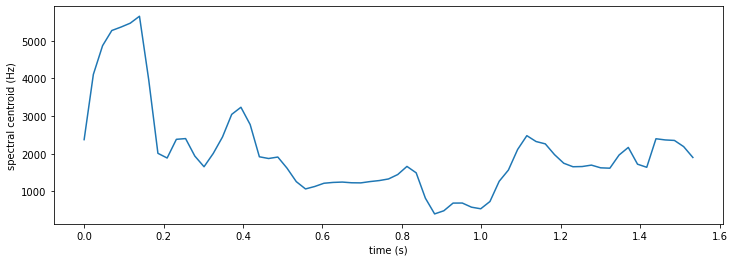

In [8]:
spectral_centroids = librosa.feature.spectral_centroid(y, sr=sr)[0]

frames = range(len(spectral_centroids))
t = librosa.frames_to_time(frames)

plt.figure(figsize=(12, 4))
plt.plot(t, spectral_centroids)
plt.xlabel('time (s)')
plt.ylabel('spectral centroid (Hz)')
plt.show()

### Spectral rolloff

The spectral rolloff represents the frequency at which high frequencies decline to 0:

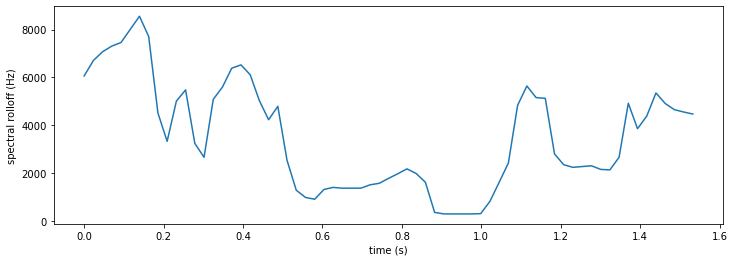

In [9]:
spectral_rolloff = librosa.feature.spectral_rolloff(y, sr=sr)[0]
plt.figure(figsize=(12, 4))
plt.plot(t, spectral_rolloff)
plt.xlabel('time (s)')
plt.ylabel('spectral rolloff (Hz)')
plt.show()

### Spectral bandwidth

The spectral bandwidth is the width of the band of signal at one-half the peak maximum (also known as full width at half maximum, or FWHM): 

Text(0, 0.5, 'Hz')

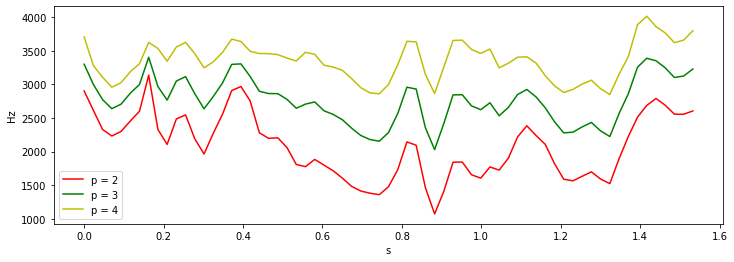

In [10]:
spectral_bandwidth_2 = librosa.feature.spectral_bandwidth(y, sr=sr)[0]
spectral_bandwidth_3 = librosa.feature.spectral_bandwidth(y, sr=sr, p=3)[0]
spectral_bandwidth_4 = librosa.feature.spectral_bandwidth(y, sr=sr, p=4)[0]
plt.figure(figsize=(12, 4))
plt.plot(t, spectral_bandwidth_2, color='r')
plt.plot(t, spectral_bandwidth_3, color='g')
plt.plot(t, spectral_bandwidth_4, color='y')
plt.legend(('p = 2', 'p = 3', 'p = 4'))
plt.xlabel('s')
plt.ylabel('Hz')

### Zero-crossing rate

This gives a measure of how many times the signal crosses the zero in a certain segment of the signal. For example, the sample we are analzying has 2903 points of zero-crossing:

In [11]:
zero_crossings = librosa.zero_crossings(y, pad=False)
print(sum(zero_crossings))

2903


### Mel-Frequency Cepstral Coefficients(MFCCs)

The MFCCs include a small set of features describing the overall shape of the spectrum of the signal. This is less easy to interpret:

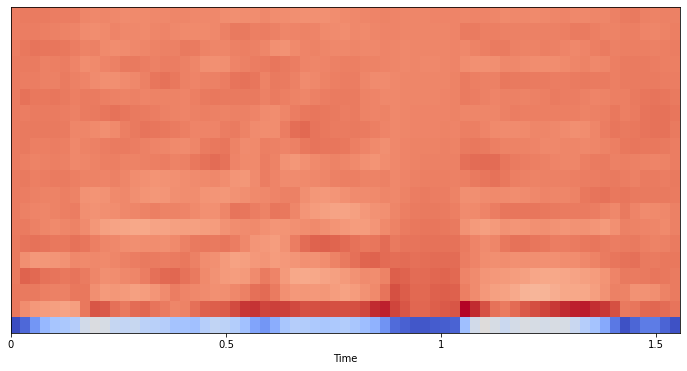

In [12]:
mfccs = librosa.feature.mfcc(y, sr=sr)

plt.figure(figsize=(12, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time')

### Chroma feature

Chroma feature is a 12-element vector representing the amount of energy in each pitch class (C, C#, D, D#, E, …, B) of the signal:

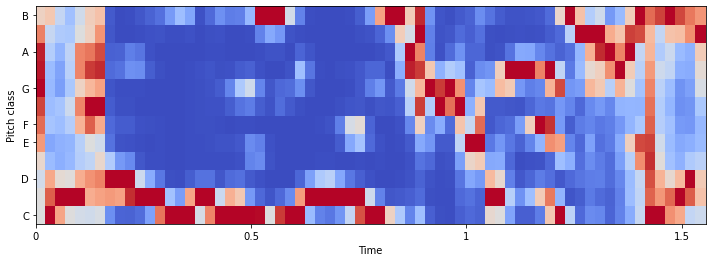

In [13]:
chromagram = librosa.feature.chroma_stft(y, sr=sr)
plt.figure(figsize=(12, 4))
librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', cmap='coolwarm')

## Importing all files

The folder contain two different sub-folders: one contains the recordings made by the young voice ('Y'), and the other one contains the recordings made by the old voice ('O'). We will be using only one of the two sets (old voice), since the tones/frequencies of the two voices could be different.

In [14]:
categories = ['angry','disgust','Fear','happy','neutral','Pleasant_surprise','Sad']

In [59]:
rmse = []
chroma_stft = []
spec_cent = []
spec_bw = []
rolloff = []
zcr = []
mfcc = []
label = []
for cat in categories:
    for file in os.listdir(main_path+'OAF_'+cat+'/'):
        print(file)
        y, sr = librosa.load(main_path+'OAF_'+cat+'/'+file)
        rmse.append(np.mean(librosa.feature.rms(y=y)))
        chroma_stft.append(np.mean(librosa.feature.chroma_stft(y=y, sr=sr)))
        spec_cent.append(np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)))
        spec_bw.append(np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)))
        rolloff.append(np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)))
        zcr.append(np.mean(librosa.feature.zero_crossing_rate(y)))
        mfcc.append(np.mean(librosa.feature.mfcc(y=y, sr=sr)))
        label.append(cat)

Now we create a dataframe containing all these quantities:

In [16]:
dict = {'rms': rmse, 
        'chroma_stft': chroma_stft,
        'spec_cent': spec_cent,
        'spec_bw': spec_bw,
        'rolloff': rolloff,
        'zcr': zcr,
        'mfcc': mfcc,
        'label': label}

df = pd.DataFrame(dict)

In [17]:
df.head()

,rms,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc,label
0,0.041608,0.302562,2029.152660,2078.273621,3513.608107,0.084582,-20.461781,angry
1,0.022707,0.287034,2019.043289,2116.384394,3467.768555,0.093827,-21.884960,angry
2,0.030000,0.288052,2764.786682,2407.262923,4971.920184,0.135844,-21.869703,angry
3,0.043194,0.293798,2333.986062,2173.363253,4022.863770,0.106571,-20.556767,angry
4,0.030693,0.247118,2181.933330,2189.628652,4068.892882,0.081463,-20.921816,angry


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1400 entries, 0 to 1399
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rms          1400 non-null   float64
 1   chroma_stft  1400 non-null   float64
 2   spec_cent    1400 non-null   float64
 3   spec_bw      1400 non-null   float64
 4   rolloff      1400 non-null   float64
 5   zcr          1400 non-null   float64
 6   mfcc         1400 non-null   float64
 7   label        1400 non-null   object 
dtypes: float64(7), object(1)
memory usage: 87.6+ KB


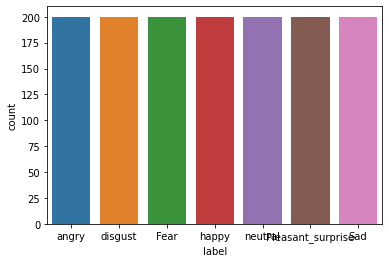

In [19]:
sns.countplot(df['label'])

#### Dataset is perfectly balanced among the different categories.

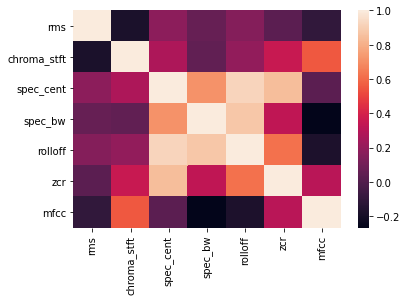

In [20]:
sns.heatmap(df.corr())

Some categories (e.g. spec_bw and rolloff) are clearly correlated with each other

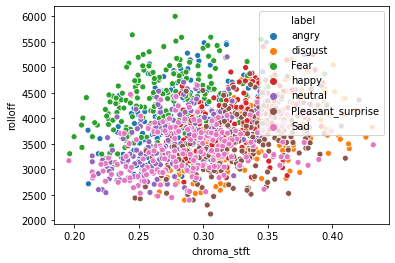

In [21]:
sns.scatterplot(x='chroma_stft',y='rolloff',data=df,hue='label')

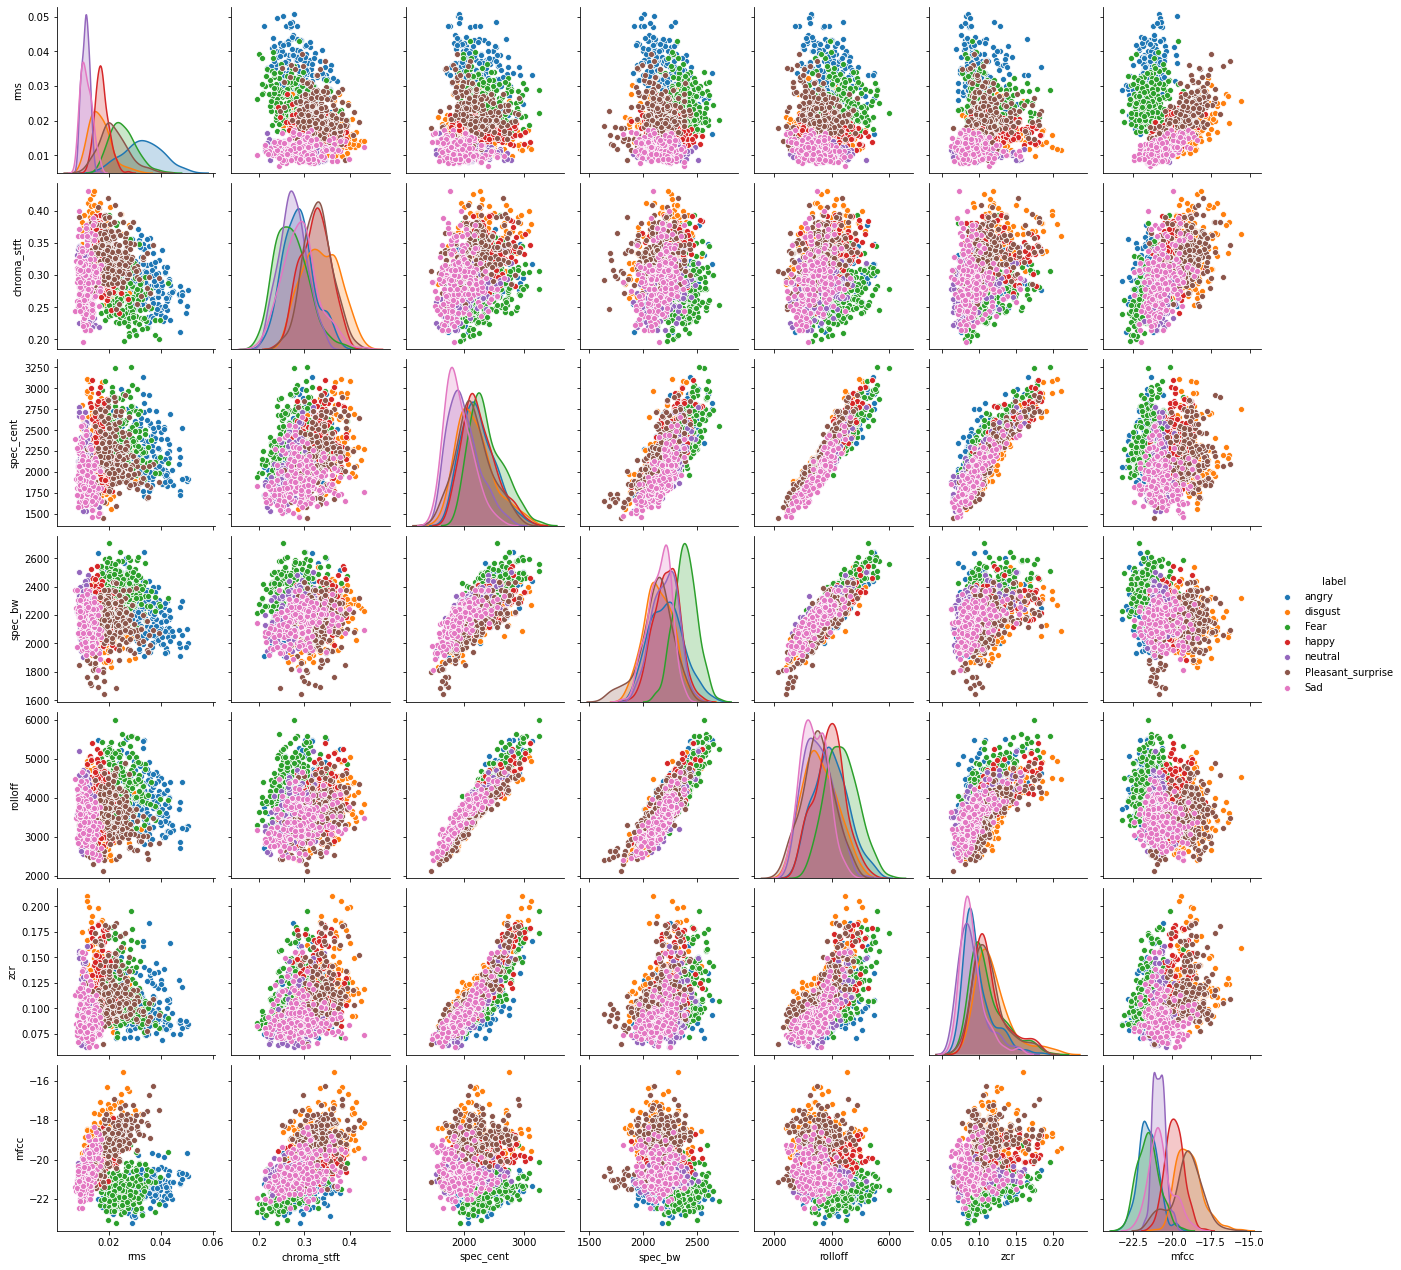

In [22]:
sns.pairplot(data=df,hue='label')

#### From these plots, we can see that the features with most discriminating power between categories are the rms and the mfcc.

### Split the dataset in train/test and scaling the features:

In [23]:
from sklearn.model_selection import train_test_split

X = df.drop('label',axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## BUILDING THE MODELS

### Support Vector Machine

In [25]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train,y_train)

SVC()

In [26]:
predictions = svc.predict(X_test)

                   precision    recall  f1-score   support

             Fear       0.94      0.94      0.94        52
Pleasant_surprise       0.67      0.73      0.70        62
              Sad       0.66      0.50      0.57        54
            angry       0.96      0.94      0.95        68
          disgust       0.73      0.77      0.75        57
            happy       0.79      0.70      0.75        71
          neutral       0.63      0.79      0.70        56

         accuracy                           0.77       420
        macro avg       0.77      0.77      0.76       420
     weighted avg       0.77      0.77      0.77       420



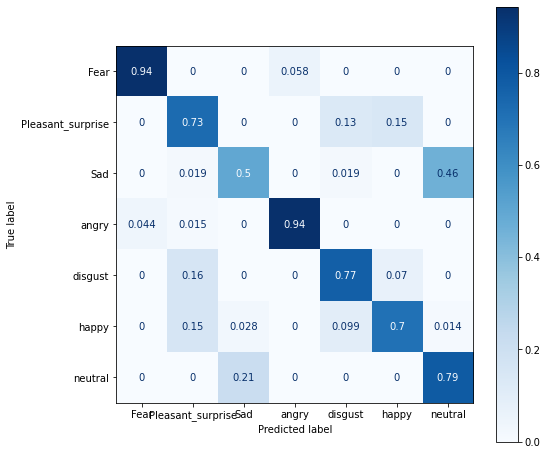

In [27]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import plot_confusion_matrix
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(svc, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()
#print(confusion_matrix(y_test,predictions))

This algorithm gives 77% overall accuracy. However we notice that there is one class ("sad") that is misclassified almost 50% of the times. Let's do a grid search to see if we can further improve:

In [28]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [29]:
from sklearn.model_selection import GridSearchCV

In [30]:
grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=3)

In [31]:
grid.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.495, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.480, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.536, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.500, total=   0.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.505, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.643, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.714, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.612, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.648, total=   0.1s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.653, total=   0.1s
[CV] C=0.1, gamma=0.01, kernel=rbf ...................................
[CV] .

[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.796, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.760, total=   0.0s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ........ C=10, gamma=0.01, kernel=rbf, score=0.770, total=   0.0s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.653, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.755, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.689, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] ....... C=10, gamma=0.001, kernel=rbf, score=0.684, total=   0.1s
[CV] C=10, gamma=0.001, kernel=rbf ...................................
[CV] .

[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.735, total=   0.0s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.806, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.776, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.755, total=   0.1s
[CV] C=1000, gamma=0.0001, kernel=rbf ................................
[CV] .... C=1000, gamma=0.0001, kernel=rbf, score=0.770, total=   0.1s


[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed:   11.0s finished


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [32]:
grid.best_params_

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}

In [33]:
predictions = grid.predict(X_test)

                   precision    recall  f1-score   support

             Fear       0.91      0.94      0.92        52
Pleasant_surprise       0.78      0.76      0.77        62
              Sad       0.72      0.63      0.67        54
            angry       0.94      0.97      0.96        68
          disgust       0.75      0.77      0.76        57
            happy       0.81      0.76      0.78        71
          neutral       0.71      0.80      0.76        56

         accuracy                           0.81       420
        macro avg       0.80      0.81      0.80       420
     weighted avg       0.81      0.81      0.81       420



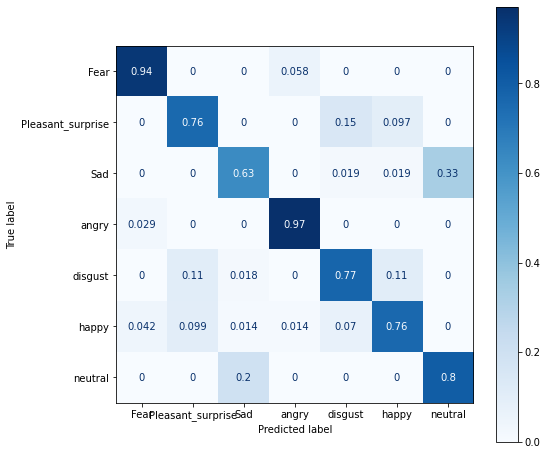

In [34]:
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(grid, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()
#print(confusion_matrix(y_test,predictions))

We improved the overall accuracy up to 81%. We can also see that the recall on the worst class ('sad') has improved to 63%.

### k-neighbors

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,y_train)

predictions = knn.predict(X_test)

                   precision    recall  f1-score   support

             Fear       0.82      0.87      0.84        52
Pleasant_surprise       0.58      0.66      0.62        62
              Sad       0.52      0.50      0.51        54
            angry       0.89      0.85      0.87        68
          disgust       0.70      0.61      0.65        57
            happy       0.70      0.65      0.67        71
          neutral       0.54      0.59      0.56        56

         accuracy                           0.68       420
        macro avg       0.68      0.68      0.68       420
     weighted avg       0.68      0.68      0.68       420



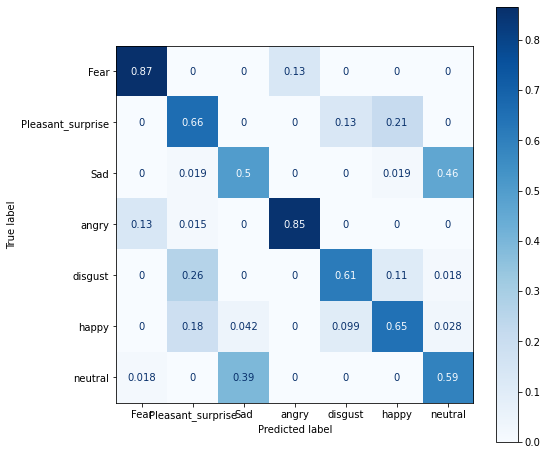

In [36]:
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(knn, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()

Overall accuracy is 68%, quite low, and some of the classes are often mislabelled. We can find the best value for the k-parameter to see if we can improve:

In [37]:
error_rate = []

for i in range(1,20):
    
    print(f"Analzying: n = {i}")
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))

Analzying: n = 1
Analzying: n = 2
Analzying: n = 3
Analzying: n = 4
Analzying: n = 5
Analzying: n = 6
Analzying: n = 7
Analzying: n = 8
Analzying: n = 9
Analzying: n = 10
Analzying: n = 11
Analzying: n = 12
Analzying: n = 13
Analzying: n = 14
Analzying: n = 15
Analzying: n = 16
Analzying: n = 17
Analzying: n = 18
Analzying: n = 19


Text(0, 0.5, 'Error Rate')

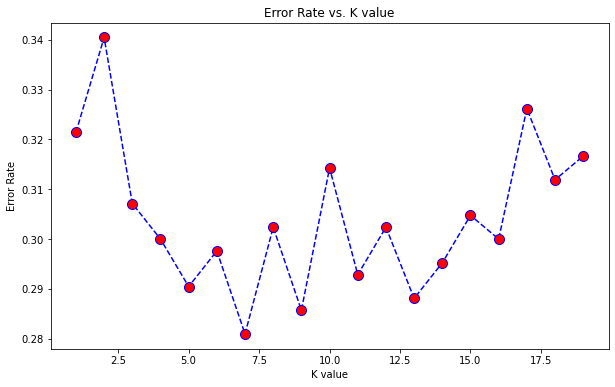

In [38]:
plt.figure(figsize=(10,6))
plt.plot(range(1,20),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K value')
plt.xlabel('K value')
plt.ylabel('Error Rate')

#### Best value for k is 7. Let's use it:

In [39]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train,y_train)

predictions = knn.predict(X_test)

                   precision    recall  f1-score   support

             Fear       0.79      0.94      0.86        52
Pleasant_surprise       0.61      0.74      0.67        62
              Sad       0.59      0.61      0.60        54
            angry       0.93      0.84      0.88        68
          disgust       0.71      0.60      0.65        57
            happy       0.75      0.63      0.69        71
          neutral       0.66      0.68      0.67        56

         accuracy                           0.72       420
        macro avg       0.72      0.72      0.72       420
     weighted avg       0.73      0.72      0.72       420



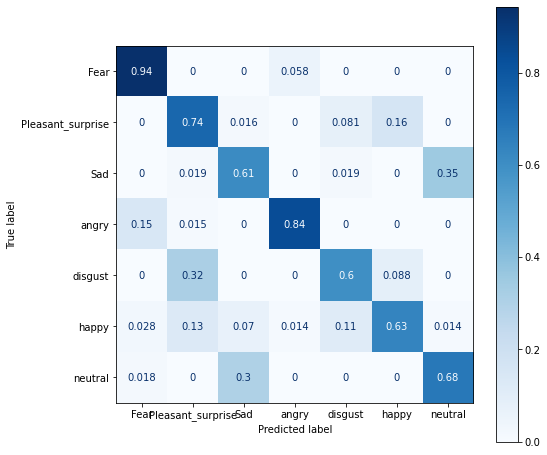

In [40]:
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(knn, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()

Overall accuracy improved to 72%, but still far from SVM.

### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)

predictions = rfc.predict(X_test)

                   precision    recall  f1-score   support

             Fear       0.80      0.94      0.87        52
Pleasant_surprise       0.63      0.73      0.68        62
              Sad       0.67      0.69      0.68        54
            angry       0.93      0.82      0.87        68
          disgust       0.75      0.70      0.73        57
            happy       0.77      0.65      0.70        71
          neutral       0.70      0.75      0.72        56

         accuracy                           0.75       420
        macro avg       0.75      0.75      0.75       420
     weighted avg       0.76      0.75      0.75       420



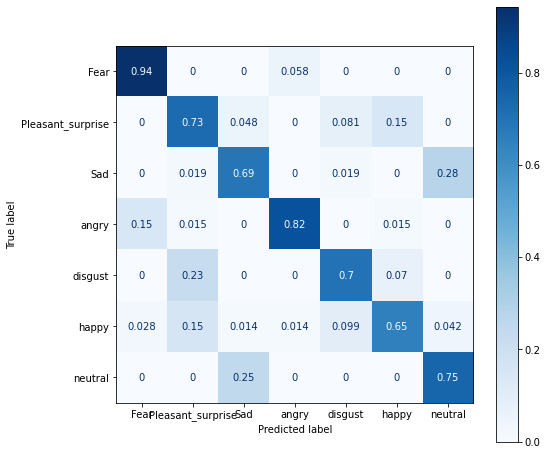

In [42]:
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(rfc, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()

Overall accuracy 75%: better than k-nearest neighbors, but still worse than SVM.

## Gradient boosting decision trees

In [43]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(eta=0.3,max_depth=5)
xgb_model.fit(X_train,y_train)

predictions = xgb_model.predict(X_test)

                   precision    recall  f1-score   support

             Fear       0.85      0.96      0.90        52
Pleasant_surprise       0.69      0.68      0.68        62
              Sad       0.71      0.76      0.73        54
            angry       0.97      0.88      0.92        68
          disgust       0.73      0.75      0.74        57
            happy       0.76      0.66      0.71        71
          neutral       0.73      0.77      0.75        56

         accuracy                           0.78       420
        macro avg       0.78      0.78      0.78       420
     weighted avg       0.78      0.78      0.78       420



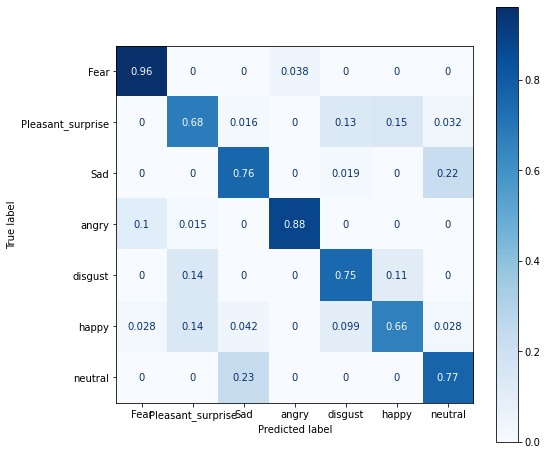

In [44]:
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(xgb_model, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()

78%: Better than random forest, but still worse than SVM. Let's fine-tune the parameters:

In [45]:
param_grid = {'max_depth':[3,4,5,6,7]} #Depth of decision tree
grid = GridSearchCV(xgb.XGBClassifier(),param_grid,refit=True,verbose=1)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   24.2s finished


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [46]:
grid.best_params_

{'max_depth': 7}

In [47]:
max_depth = grid.best_params_['max_depth']
param_grid = {'alpha':[0.1,1,10], 'gamma': [0,1], 'min_child_weight':[1,3,5], 'eta':[0.01, 0.1, 0.2, 0.3]}
grid = GridSearchCV(xgb.XGBClassifier(max_depth = max_depth),param_grid,refit=True,verbose=3)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] alpha=0.1, eta=0.01, gamma=0, min_child_weight=1 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.1, eta=0.01, gamma=0, min_child_weight=1, score=0.684, total=   2.2s
[CV] alpha=0.1, eta=0.01, gamma=0, min_child_weight=1 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV]  alpha=0.1, eta=0.01, gamma=0, min_child_weight=1, score=0.704, total=   1.8s
[CV] alpha=0.1, eta=0.01, gamma=0, min_child_weight=1 ................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.9s remaining:    0.0s


[CV]  alpha=0.1, eta=0.01, gamma=0, min_child_weight=1, score=0.709, total=   1.7s
[CV] alpha=0.1, eta=0.01, gamma=0, min_child_weight=1 ................
[CV]  alpha=0.1, eta=0.01, gamma=0, min_child_weight=1, score=0.673, total=   1.6s
[CV] alpha=0.1, eta=0.01, gamma=0, min_child_weight=1 ................
[CV]  alpha=0.1, eta=0.01, gamma=0, min_child_weight=1, score=0.750, total=   1.6s
[CV] alpha=0.1, eta=0.01, gamma=0, min_child_weight=3 ................
[CV]  alpha=0.1, eta=0.01, gamma=0, min_child_weight=3, score=0.679, total=   1.5s
[CV] alpha=0.1, eta=0.01, gamma=0, min_child_weight=3 ................
[CV]  alpha=0.1, eta=0.01, gamma=0, min_child_weight=3, score=0.730, total=   1.4s
[CV] alpha=0.1, eta=0.01, gamma=0, min_child_weight=3 ................
[CV]  alpha=0.1, eta=0.01, gamma=0, min_child_weight=3, score=0.730, total=   1.6s
[CV] alpha=0.1, eta=0.01, gamma=0, min_child_weight=3 ................
[CV]  alpha=0.1, eta=0.01, gamma=0, min_child_weight=3, score=0.684, total= 

[CV]  alpha=0.1, eta=0.1, gamma=1, min_child_weight=5, score=0.750, total=   1.1s
[CV] alpha=0.1, eta=0.1, gamma=1, min_child_weight=5 .................
[CV]  alpha=0.1, eta=0.1, gamma=1, min_child_weight=5, score=0.745, total=   1.3s
[CV] alpha=0.1, eta=0.1, gamma=1, min_child_weight=5 .................
[CV]  alpha=0.1, eta=0.1, gamma=1, min_child_weight=5, score=0.714, total=   1.2s
[CV] alpha=0.1, eta=0.1, gamma=1, min_child_weight=5 .................
[CV]  alpha=0.1, eta=0.1, gamma=1, min_child_weight=5, score=0.760, total=   1.1s
[CV] alpha=0.1, eta=0.2, gamma=0, min_child_weight=1 .................
[CV]  alpha=0.1, eta=0.2, gamma=0, min_child_weight=1, score=0.740, total=   1.1s
[CV] alpha=0.1, eta=0.2, gamma=0, min_child_weight=1 .................
[CV]  alpha=0.1, eta=0.2, gamma=0, min_child_weight=1, score=0.755, total=   1.1s
[CV] alpha=0.1, eta=0.2, gamma=0, min_child_weight=1 .................
[CV]  alpha=0.1, eta=0.2, gamma=0, min_child_weight=1, score=0.745, total=   1.1s


[CV]  alpha=0.1, eta=0.3, gamma=1, min_child_weight=3, score=0.740, total=   1.4s
[CV] alpha=0.1, eta=0.3, gamma=1, min_child_weight=3 .................
[CV]  alpha=0.1, eta=0.3, gamma=1, min_child_weight=3, score=0.724, total=   1.2s
[CV] alpha=0.1, eta=0.3, gamma=1, min_child_weight=3 .................
[CV]  alpha=0.1, eta=0.3, gamma=1, min_child_weight=3, score=0.750, total=   1.4s
[CV] alpha=0.1, eta=0.3, gamma=1, min_child_weight=3 .................
[CV]  alpha=0.1, eta=0.3, gamma=1, min_child_weight=3, score=0.735, total=   1.6s
[CV] alpha=0.1, eta=0.3, gamma=1, min_child_weight=3 .................
[CV]  alpha=0.1, eta=0.3, gamma=1, min_child_weight=3, score=0.750, total=   1.4s
[CV] alpha=0.1, eta=0.3, gamma=1, min_child_weight=5 .................
[CV]  alpha=0.1, eta=0.3, gamma=1, min_child_weight=5, score=0.714, total=   1.3s
[CV] alpha=0.1, eta=0.3, gamma=1, min_child_weight=5 .................
[CV]  alpha=0.1, eta=0.3, gamma=1, min_child_weight=5, score=0.735, total=   1.1s


[CV]  alpha=1, eta=0.1, gamma=0, min_child_weight=5, score=0.776, total=   1.5s
[CV] alpha=1, eta=0.1, gamma=1, min_child_weight=1 ...................
[CV]  alpha=1, eta=0.1, gamma=1, min_child_weight=1, score=0.730, total=   1.6s
[CV] alpha=1, eta=0.1, gamma=1, min_child_weight=1 ...................
[CV]  alpha=1, eta=0.1, gamma=1, min_child_weight=1, score=0.735, total=   1.5s
[CV] alpha=1, eta=0.1, gamma=1, min_child_weight=1 ...................
[CV]  alpha=1, eta=0.1, gamma=1, min_child_weight=1, score=0.750, total=   1.4s
[CV] alpha=1, eta=0.1, gamma=1, min_child_weight=1 ...................
[CV]  alpha=1, eta=0.1, gamma=1, min_child_weight=1, score=0.709, total=   1.6s
[CV] alpha=1, eta=0.1, gamma=1, min_child_weight=1 ...................
[CV]  alpha=1, eta=0.1, gamma=1, min_child_weight=1, score=0.740, total=   1.6s
[CV] alpha=1, eta=0.1, gamma=1, min_child_weight=3 ...................
[CV]  alpha=1, eta=0.1, gamma=1, min_child_weight=3, score=0.730, total=   1.5s
[CV] alpha=1, 

[CV]  alpha=1, eta=0.3, gamma=0, min_child_weight=3, score=0.745, total=   1.0s
[CV] alpha=1, eta=0.3, gamma=0, min_child_weight=5 ...................
[CV]  alpha=1, eta=0.3, gamma=0, min_child_weight=5, score=0.730, total=   0.9s
[CV] alpha=1, eta=0.3, gamma=0, min_child_weight=5 ...................
[CV]  alpha=1, eta=0.3, gamma=0, min_child_weight=5, score=0.765, total=   1.0s
[CV] alpha=1, eta=0.3, gamma=0, min_child_weight=5 ...................
[CV]  alpha=1, eta=0.3, gamma=0, min_child_weight=5, score=0.760, total=   1.1s
[CV] alpha=1, eta=0.3, gamma=0, min_child_weight=5 ...................
[CV]  alpha=1, eta=0.3, gamma=0, min_child_weight=5, score=0.719, total=   1.0s
[CV] alpha=1, eta=0.3, gamma=0, min_child_weight=5 ...................
[CV]  alpha=1, eta=0.3, gamma=0, min_child_weight=5, score=0.760, total=   0.9s
[CV] alpha=1, eta=0.3, gamma=1, min_child_weight=1 ...................
[CV]  alpha=1, eta=0.3, gamma=1, min_child_weight=1, score=0.750, total=   1.6s
[CV] alpha=1, 

[CV]  alpha=10, eta=0.1, gamma=0, min_child_weight=1, score=0.679, total=   1.2s
[CV] alpha=10, eta=0.1, gamma=0, min_child_weight=1 ..................
[CV]  alpha=10, eta=0.1, gamma=0, min_child_weight=1, score=0.724, total=   1.1s
[CV] alpha=10, eta=0.1, gamma=0, min_child_weight=3 ..................
[CV]  alpha=10, eta=0.1, gamma=0, min_child_weight=3, score=0.689, total=   0.9s
[CV] alpha=10, eta=0.1, gamma=0, min_child_weight=3 ..................
[CV]  alpha=10, eta=0.1, gamma=0, min_child_weight=3, score=0.719, total=   1.0s
[CV] alpha=10, eta=0.1, gamma=0, min_child_weight=3 ..................
[CV]  alpha=10, eta=0.1, gamma=0, min_child_weight=3, score=0.724, total=   1.0s
[CV] alpha=10, eta=0.1, gamma=0, min_child_weight=3 ..................
[CV]  alpha=10, eta=0.1, gamma=0, min_child_weight=3, score=0.689, total=   1.1s
[CV] alpha=10, eta=0.1, gamma=0, min_child_weight=3 ..................
[CV]  alpha=10, eta=0.1, gamma=0, min_child_weight=3, score=0.714, total=   1.2s
[CV] al

[CV]  alpha=10, eta=0.2, gamma=1, min_child_weight=5, score=0.684, total=   1.1s
[CV] alpha=10, eta=0.2, gamma=1, min_child_weight=5 ..................
[CV]  alpha=10, eta=0.2, gamma=1, min_child_weight=5, score=0.679, total=   1.0s
[CV] alpha=10, eta=0.2, gamma=1, min_child_weight=5 ..................
[CV]  alpha=10, eta=0.2, gamma=1, min_child_weight=5, score=0.668, total=   1.0s
[CV] alpha=10, eta=0.3, gamma=0, min_child_weight=1 ..................
[CV]  alpha=10, eta=0.3, gamma=0, min_child_weight=1, score=0.689, total=   0.6s
[CV] alpha=10, eta=0.3, gamma=0, min_child_weight=1 ..................
[CV]  alpha=10, eta=0.3, gamma=0, min_child_weight=1, score=0.699, total=   0.6s
[CV] alpha=10, eta=0.3, gamma=0, min_child_weight=1 ..................
[CV]  alpha=10, eta=0.3, gamma=0, min_child_weight=1, score=0.730, total=   0.6s
[CV] alpha=10, eta=0.3, gamma=0, min_child_weight=1 ..................
[CV]  alpha=10, eta=0.3, gamma=0, min_child_weight=1, score=0.668, total=   0.6s
[CV] al

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:  7.5min finished


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=7, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=N

In [48]:
grid.best_params_

{'alpha': 1, 'eta': 0.3, 'gamma': 0, 'min_child_weight': 1}

In [49]:
predictions = grid.predict(X_test)

                   precision    recall  f1-score   support

             Fear       0.89      0.98      0.94        52
Pleasant_surprise       0.69      0.69      0.69        62
              Sad       0.68      0.72      0.70        54
            angry       0.98      0.93      0.95        68
          disgust       0.73      0.75      0.74        57
            happy       0.77      0.68      0.72        71
          neutral       0.73      0.77      0.75        56

         accuracy                           0.79       420
        macro avg       0.78      0.79      0.79       420
     weighted avg       0.79      0.79      0.79       420



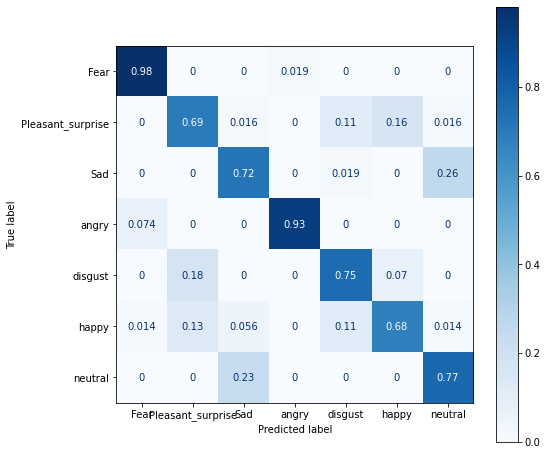

In [50]:
print(classification_report(y_test,predictions))

fig, ax = plt.subplots(figsize=(8, 8))
plot_confusion_matrix(grid, X_test, y_test, ax=ax, cmap='Blues', normalize='true')
plt.show()

Overall accuracy to 79% - closer to SVM, althouth a bit lower. Interestingly, we can note that the class 'sad' is no longer the most mislabelled class.

### Conclusions:

The different algorithms we tested gave the following overall accuracy:
* Support Vector Machine: 81%
* k-nearest neighbors: 72%
* Random forest: 75%
* Gradient boosting decision trees: 79%

Overall, support vector machine gives the best result, followed by gradient boosting trees.

#### Aknowledgments

Thanks to the University of Toronto for putting together this dataset, which can be found at this link:
https://tspace.library.utoronto.ca/handle/1807/24487